# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

In [33]:
#importing all the main modules
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from olist.seller import Seller
from olist.order import Order
from olist.data import Olist

In [3]:
#getting the training data
training_data = Seller().get_training_data()

(2967, 15)

In [4]:
#getting the main datasets
data = Olist().get_data()
#generating datasets to be merged
order_reviews = data['order_reviews']
order_items = data['order_items']
orders = data['orders']

In [28]:
#checking the materiality of taking the non-delivered orders out of scope of our analysis
non_del_mat = round((orders[orders['order_status']=='delivered'].shape[0] - orders.shape[0])/orders.shape[0]*100,2)

print(f'The materiality of non-delivered orders is at {non_del_mat}%.\
 We deem it acceptable to drop non-delivered orders from our analysis')

The materiality of non-delivered orders is at -2.98%. We deem it acceptable to drop non-delivered orders from our analysis


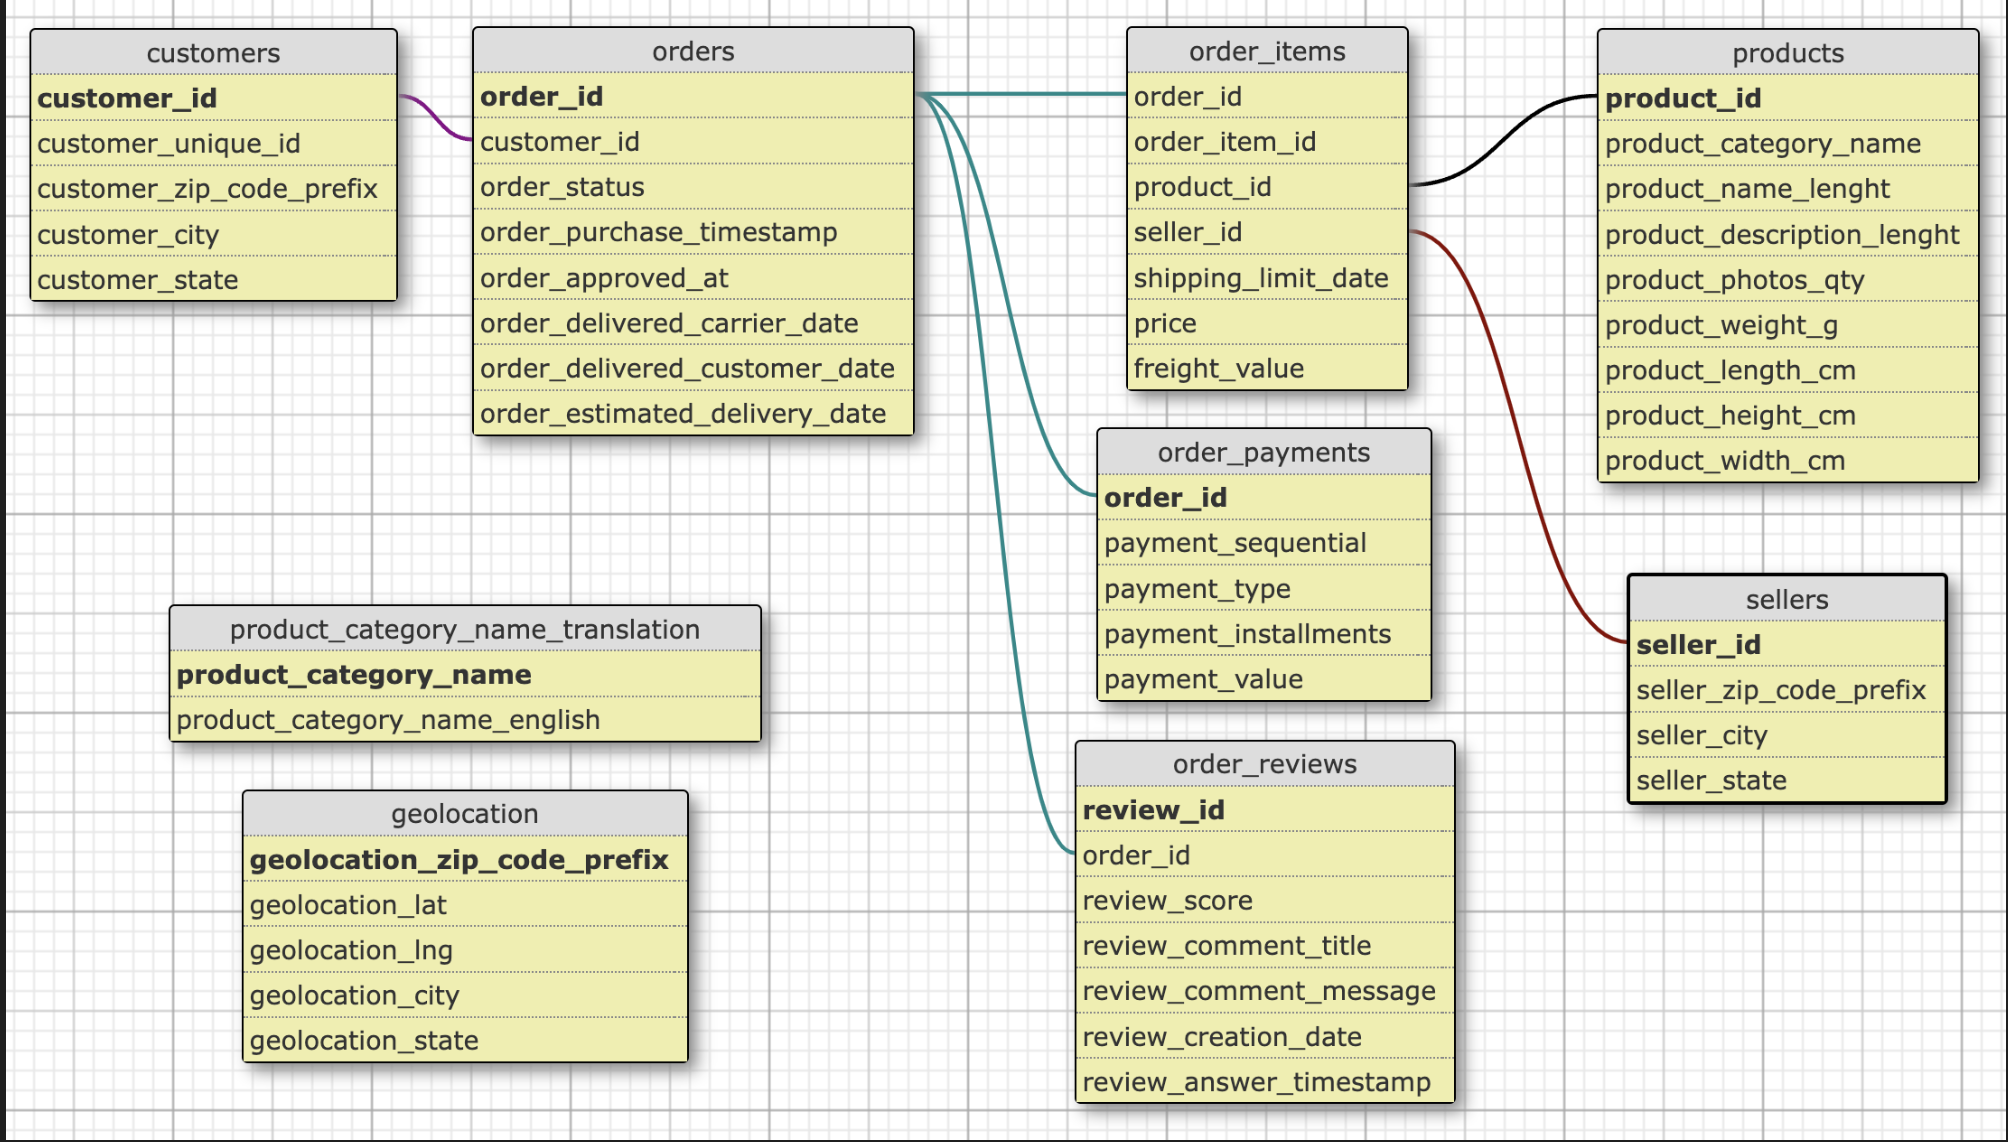

In [ ]:
#filtering the orders dataset to only have delivered orders
orders_delivered = orders[orders['order_status']=='delivered']

In [7]:
#merging the tables together
review_items = order_reviews.merge(order_items, on="order_id")\
                        .merge(orders_delivered,on='order_id')

#placing seller_id in the first column
seller_id = review_items.pop('seller_id')
review_items.insert(0,'seller_id',seller_id)

In [29]:
#cost of bad reviews
review_costs = {1 : 100,
                2 : 50,
                3 : 40,
                4 : 0,
                5 : 0}

#multiplying the cost per review to get the costs for each seller
review_items['cost_of_reviews'] = review_items['review_score']\
                                .map(review_costs)*review_items['review_score']

cost_of_reviews = review_items.pop('cost_of_reviews')
review_items.insert(4,'cost_of_reviews',cost_of_reviews)

In [9]:
#aggregating the costs of review for each seller
seller_review_costs_temp = review_items.groupby('seller_id')\
                                       ['cost_of_reviews'].sum()\
                                      .reset_index()

In [11]:
#Merging the training data dataset with the seller dataset
sellers_master = training_data.merge(seller_review_costs_temp,on='seller_id')

In [13]:
#Define the revenue per seller per sale, revenue seller platform subscription
#and total revenue from the sellers

sellers_master['seller_sales_revenue'] = sellers_master['sales'] * 0.1
sellers_master['seller_subscription_revenue'] = sellers_master['months_on_olist'] * 80
sellers_master['seller_total_revenue'] = sellers_master['seller_sales_revenue'] + sellers_master['seller_subscription_revenue']

sellers_master['sellers_profits'] = sellers_master['seller_total_revenue'] - sellers_master['cost_of_reviews']

In [14]:
sellers_master.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_reviews,seller_sales_revenue,seller_subscription_revenue,seller_total_revenue,sellers_profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.000000,220,21.870,320.0,341.870,121.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.731707,0.048780,4.560976,220,1170.307,1120.0,2290.307,2070.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.000000,0.000000,5.000000,0,15.800,0.0,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,1.000000,0.000000,5.000000,0,7.999,0.0,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,0.000000,1.000000,1.000000,100,16.799,0.0,16.799,-83.201


In [15]:
#re-order the table columns and sort the sellers by the ascending profitability

sellers_master_sorted = sellers_master.sort_values('sellers_profits',ascending=True)

columns_order_old = sellers_master_sorted.columns
columns_order_new = ['seller_id',\
                    'sellers_profits',\
                    'seller_total_revenue',\
                    'seller_sales_revenue',\
                    'seller_subscription_revenue',\
                    'cost_of_reviews',\
                    'sales',\
                    'review_score',\
                    'seller_city',\
                    'seller_state',\
                    'share_of_five_stars',\
                    'share_of_one_stars',\
                    'quantity',\
                    'quantity_per_order',\
                    'delay_to_carrier',\
                    'wait_time',\
                    'date_first_sale',\
                    'date_last_sale',\
                    'months_on_olist',\
                    'n_orders']

sellers_master_sor_ord = sellers_master_sorted[columns_order_new].reset_index()

sellers_master_sor_ord = sellers_master_sor_ord.drop('index',axis=1)


Text(0.5, 1.0, 'Sellers Profits Distribution')

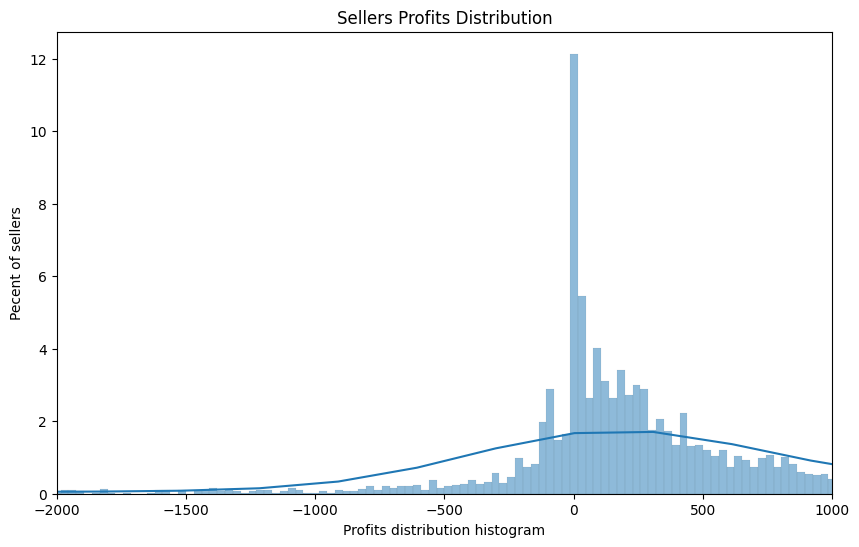

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(sellers_master_sor_ord['sellers_profits'],stat='percent',bins=2000,kde=True)
plt.xlim(-2000,1000)
plt.xlabel('Profits distribution histogram')
plt.ylabel('Pecent of sellers')
plt.title('Sellers Profits Distribution')

In [17]:
percent_loss_sellers = (sellers_master_sorted[sellers_master_sorted['sellers_profits']<0].count())\
    / sellers_master_sorted['sellers_profits'].shape[0]

f"Loss-making Sellers comprise {round(percent_loss_sellers[0]*100,1)}% \
of the total Sellers on Olist platform"

'Loss-making Sellers comprise 23.4% of the total Sellers on Olist platform'

In [18]:
#select profitable and non-profitable

non_prof_sellers = sellers_master_sor_ord[sellers_master_sor_ord['sellers_profits']<0]

prof_sellers = sellers_master_sor_ord[sellers_master_sor_ord['sellers_profits']>0]

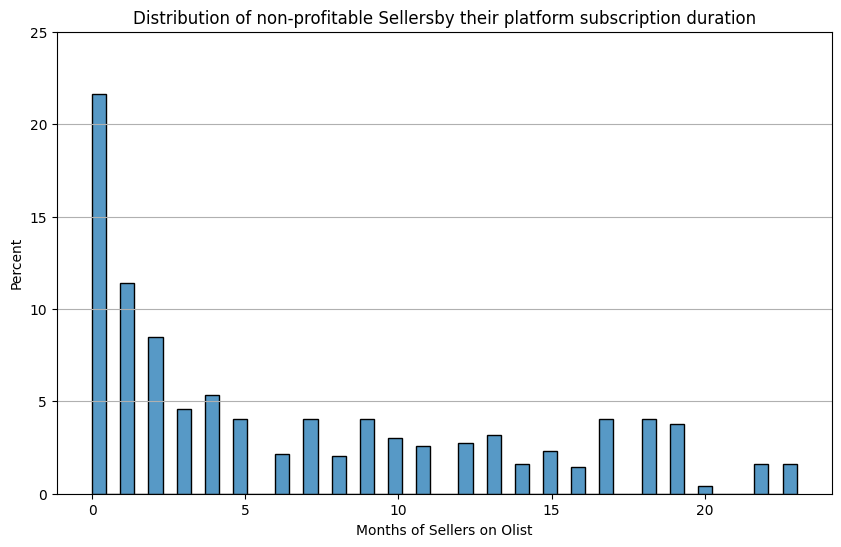

In [19]:
#check of the distribution of review scores for the
plt.figure(figsize=(10,6))
sns.histplot(non_prof_sellers['months_on_olist'],bins=50,stat='percent')
plt.ylim(0,25)
plt.ylim(0,25)
plt.title('Distribution of non-profitable Sellers\
by their platform subscription duration')
plt.xlabel('Months of Sellers on Olist')

plt.grid(True,axis='y')

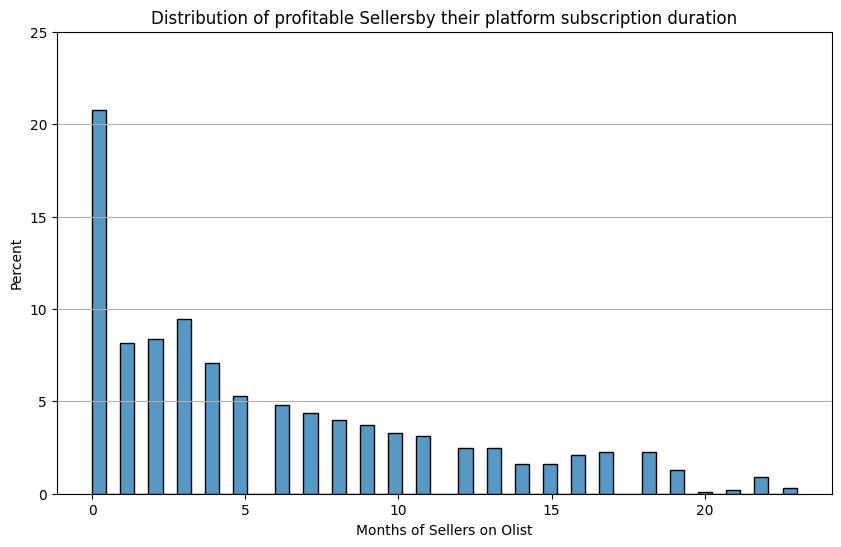

In [20]:
plt.figure(figsize=(10,6))

sns.histplot(prof_sellers['months_on_olist'],bins=50,stat='percent')
plt.ylim(0,25)
plt.title('Distribution of profitable Sellers\
by their platform subscription duration')
plt.xlabel('Months of Sellers on Olist')

plt.grid(True,axis='y')

Text(0, 0.5, 'Distribution Percentage')

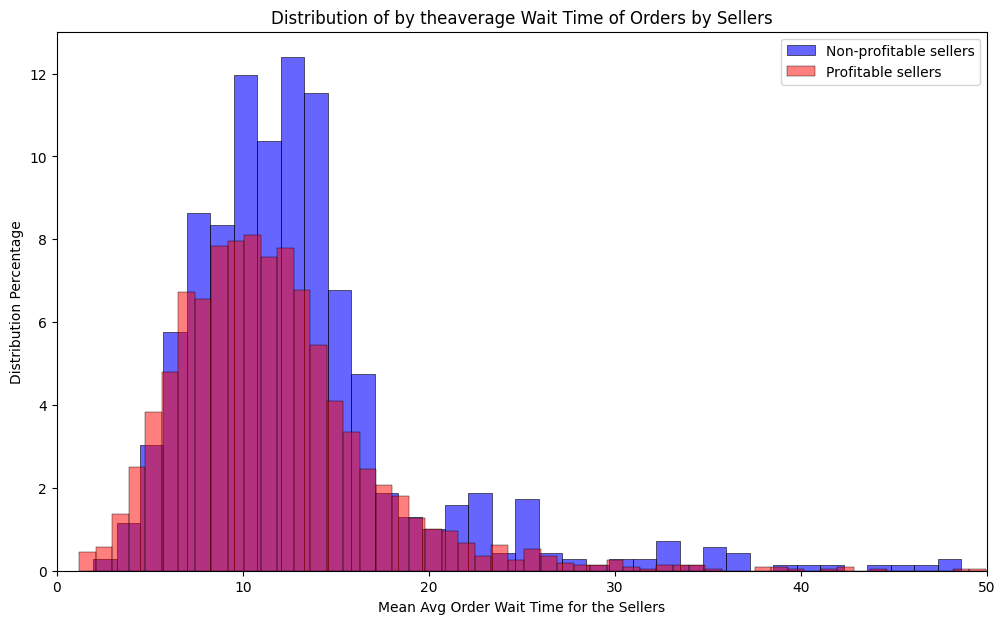

In [32]:
#check of the distribution of review scores for the
plt.figure(figsize=(12,7))

plot1 = sns.histplot(non_prof_sellers['wait_time'],stat='percent',color='blue',alpha=0.6,label='Non-profitable sellers')
plot2 = sns.histplot(prof_sellers['wait_time'],stat='percent',color='red',alpha=0.5,label='Profitable sellers')
plt.xlim(0,50)

plt.legend()
plt.title('Distribution of by theaverage Wait Time of Orders by Sellers')
plt.xlabel('Mean Avg Order Wait Time for the Sellers')
plt.ylabel('Distribution Percentage')

In [24]:
alpha = 3157.27
beta = 978.23

ops_profits_list = []
ops_profit_margin = []
sellers_iterative = sellers_master_sor_ord.copy()

for i in range(sellers_iterative.shape[0]):
    it_costs =  alpha * sellers_master_sor_ord.shape[0]**(1/2)\
            + beta * sellers_master_sor_ord['quantity'].sum()**(1/2)

    profit = sellers_iterative['sellers_profits'].sum() - it_costs
    profit_margin = 100*(profit / (sellers_iterative['seller_total_revenue'].sum()))

    ops_profits_list.append(profit)
    ops_profit_margin.append(profit_margin)

    sellers_iterative = sellers_iterative.iloc[1:].reset_index(drop=True)

In [25]:
max_profit = max(ops_profits_list)
max_profit_rounded = round(max_profit,2)

opt_removal = ops_profits_list.index(max_profit)

print(f'Given all factors remain constant, removing {opt_removal} worst performing Sellers measured by profitability\
    would allow to achieve the profit level in the amount of BRL {max_profit_rounded}')

Given all factors remain constant, removing 694 worst performing Sellers measured by profitability    would allow to achieve the profit level in the amount of BRL 591555.39


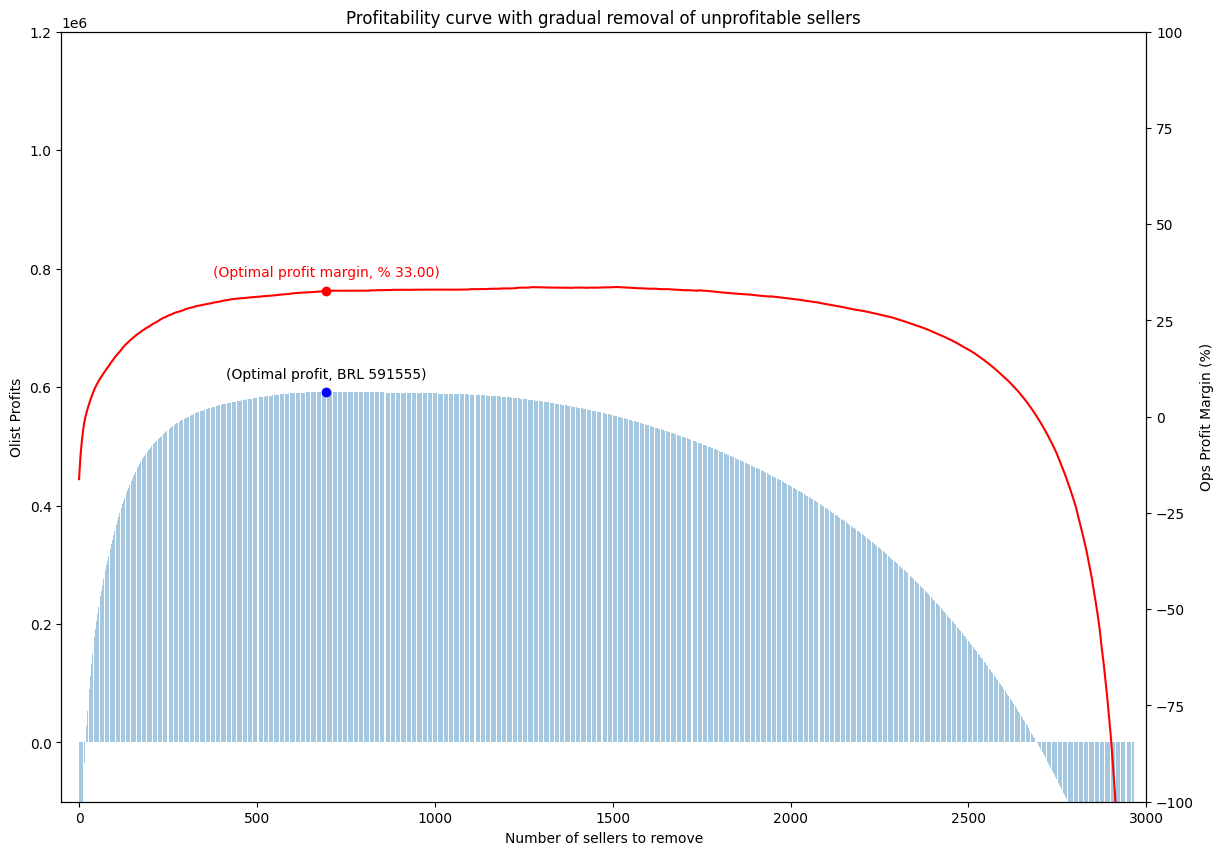

In [27]:
# Correcting the plot code and adding grid and coordinate annotations

fig, ax1 = plt.subplots(figsize=(14, 10))

# Plotting ops_profits_list as a bar plot
ax1.bar(range(len(ops_profits_list)), ops_profits_list, alpha=0.4)
ax1.set_xlabel('Number of sellers to remove')
ax1.set_ylabel('Olist Profits')
ax1.set_xlim(-50, 3000)
ax1.set_ylim(-100000, 1200000)

# Highlighting the specific point with opt_removal
ax1.plot(opt_removal, ops_profits_list[opt_removal], 'bo')  # Blue dot on bar plot
ax1.annotate(f'(Optimal profit, BRL {round(ops_profits_list[opt_removal])})',
             (opt_removal, ops_profits_list[opt_removal]),
             textcoords="offset points", xytext=(0,10), ha='center')

# Creating a second y-axis for ops_profit_margin as a line plot
ax2 = ax1.twinx()
ax2.plot(range(len(ops_profit_margin)), ops_profit_margin, color='red')
ax2.set_ylabel('Ops Profit Margin (%)')
ax2.set_ylim(-100, 100)

# Highlighting the specific point with opt_removal on the second y-axis
ax2.plot(opt_removal, ops_profit_margin[opt_removal], 'ro')  # Red dot on line plot
ax2.annotate(f'(Optimal profit margin, % {round(ops_profit_margin[opt_removal],0):.2f})',
             (opt_removal, ops_profit_margin[opt_removal]),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title("Profitability curve with gradual removal of unprofitable sellers")
#plt.grid(True)
plt.show()